# [ICR] Easy understanding for Beginner

 


今回のお題は、56個の加齢に関する健康特性をもとに3つの病状のいずれかにかかっているかどうかを予測するというものです。  
ちょっと分かりにくい表現ですし、「健康特性」も「3つの病状」のどちらも匿名化されているのでイメージしにくいのですが、恐らく、血圧や肥満度等の指標をもとに3大成人病（がん、心疾患、脳血管疾患）にかかっているかどうかを予測するというものだと思います。   


# **Libraries**

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
pd.set_option('display.max_columns', None)
import xgboost as xgb

# **Introduction**

データのダウンロード

In [3]:
train_df  = pd.read_csv('./data/train.csv')
test_df   = pd.read_csv('./data/test.csv')
greeks_df = pd.read_csv('./data/greeks.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
train_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,A,51.618996,78.526968,65.821872,29.708112,0.296850,17167.209610,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,27.1887,285.628059,344.644105,505.006814,257.432377,61.910576,0.772304,85.233928,6.682597,0.038208,1.050225,0.761025,39.852923,2.146113,33.648

一番右の「Class」というのが予測対象で、「1」が3大疾病にかかっている、「0」がかかっていない、を表します。
トレーニングデータ全体で617レコードということなので、Kaggleのコンペにしてはかなり少ないデータです。

In [5]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,615.000000,614.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,21.419492,231.322223,98.328737,1218.133238,550.632525,77.104151,0.688801,90.251735,11.241064,0.030615,1.403761,0.742262,36.917590,1.383792,27.165653,51.128326,401.901299,0.633884,0.367002,146.972099,94.795377,26.370568,1.802900,1.924830,26.388989,9.072700,3.064778,1731.248215,0.305107,69.582596,105.060712,69.117005,71.341526,6.930086,10306.810737,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,3.478278,183.992505,96.479371,7575.293707,2076.371275,159.049302,0.263994,51.585130,13.571133,0.014808,1.922210,0.281195,17.266347,0.538717,14.645993,21.210888,317.745623,1.912384,0.112989,86.084419,28.243187,8.038825,9.034721,1.484555,18.116679,6.200281,2.058344,1790.227476,1.847499,38.555707,68.445620,390.187057,165.551545,64.754262,11331.294051,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,9.886800,72.948951,1.331155,51.216883,257.432377,12.499760,0.176874,23.387600,0.510888,0.003184,1.050225,0.069225,13.784111,0.137925,7.030640,6.906400,35.998895,0.238680,0.040995,60.232470,10.345600,6.339496,0.005518,1.743070,0.804068,4.926396,0.286201,185.594100,0.003042,5.394675,78.526968,3.828384,7.534128,0.296850,1563.136688,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,19.420500,156.847239,27.834425,424.990642,257.432377,23.317567,0.563688,64.724192,5.066306,0.023482,1.050225,0.589575,29.782467,1.070298,7.030640,37.942520,188.815690,0.238680,0.295164,102.703553,78.232240,20.888264,0.005518,1.743070,14.715792,5.965392,1.648679,1111.160625,0.003042,30.927468,78.526968,4.324656,25.815384,0.296850,5164.666260,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,21.186000,193.908816,61.642115,627.417402,257.432377,42.554330,0.658715,79.819104,9.123000,0.027860,1.050225,0.730800,34.835130,1.351665,36.019104,49.180940,307.509595,0.238680,0.358023,130.050630,96.264960,25.248800,0.251741,1.743070,21.642456,8.149404,2.616119,1493.817413,0.085176,71.949306,78.526968,22.641144,36.394008,1.870155,7345.143424,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,23.657700,247.803462,134.009015,975.649259,257.432377,77.310097,0.772206,99.813520,13.565901,0.034427,1.228445,0.859350,40.529401,1.660617,37.935832,61.408760,507.896200,0.238680,0.426348,165.836955,110.640680,30.544224,1.058690,1.743070,34.058344,10.503048,3.910070,1905.701475,0.237276,109.125159,112.766654,49.085352,56.714448,4.88021

* AB-GLの匿名化された健康特性。EJ以外は数値データとなっている。
* 617のデータが揃っていないカラムがある。データが欠損している。
* MAX値が平均値と大きく乖離している「外れ値」が含まれている。

# **まずはシンプルにLGBMに投入してみる**

EJだけはカテゴリになっているので数値に置き換えます。

In [6]:
all_cols = train_df.columns
non_use_cols = ['Id', 'Class']
feature_cols = [col for col in all_cols if col not in non_use_cols]
print(feature_cols)

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']


In [7]:
train_df['EJ'] = train_df['EJ'].replace('A', 0).replace('B', 1)
train_df['EJ']

0      1
1      0
2      1
3      1
4      1
      ..
612    0
613    1
614    0
615    1
616    0
Name: EJ, Length: 617, dtype: int64

In [8]:
train_df[feature_cols].head() #EJ列の確認

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614


In [9]:
y = train_df['Class'].copy()
x = train_df[feature_cols].copy()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model = lgbm.LGBMClassifier(n_estimators=300)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = log_loss(y_test, y_pred)
    scores.append(score)
    
mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}' )

Logloss_Score 1: 2.325396992846268
Logloss_Score 2: 2.0347223687404847
Logloss_Score 3: 1.4651891621592337
Logloss_Score 4: 2.930378324318468
Logloss_Score 5: 2.637340491886621
Logloss_mean: 2.2786054679902152


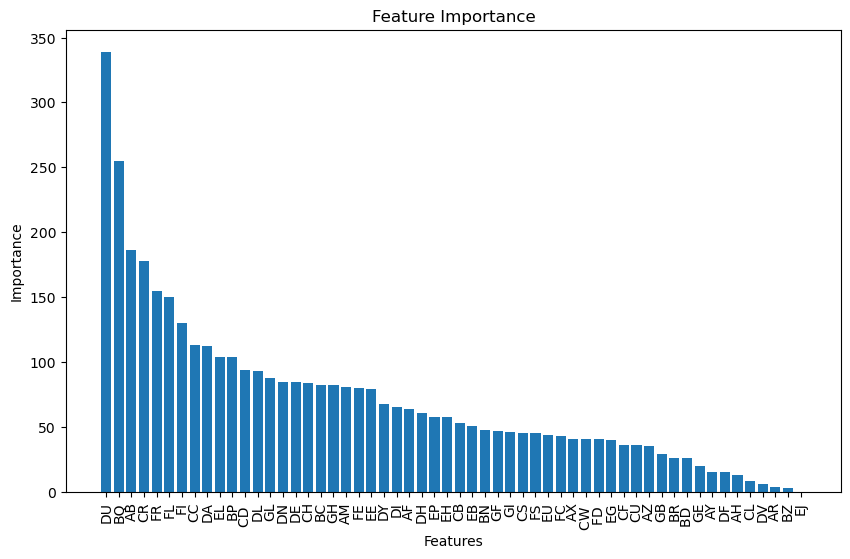

In [10]:
importance = model.feature_importances_
feature_names = feature_cols

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

LogLossは3に近いものまである。

# XGBoostを使ってモデル構築してみる

In [11]:

y = train_df['Class'].copy()
x = train_df[feature_cols].copy()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model = xgb.XGBClassifier()

# ハイパーパラメータのグリッドを定義
param_grid = {
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# GridSearchCVを使用してハイパーパラメータのチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
grid_search.fit(x, y)

# 最適なモデルとハイパーパラメータを取得
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

# ベストモデルを使用して評価
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict_proba(X_test)[:, 1]
    score = log_loss(y_test, y_pred)
    scores.append(score)
    
mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}')



Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 1.0}
Logloss_Score 1: 0.14238323538835565
Logloss_Score 2: 0.21125105570346392
Logloss_Score 3: 0.13769680269548515
Logloss_Score 4: 0.28159615291014917
Logloss_Score 5: 0.17127614600378488
Logloss_mean: 0.18884067854024775


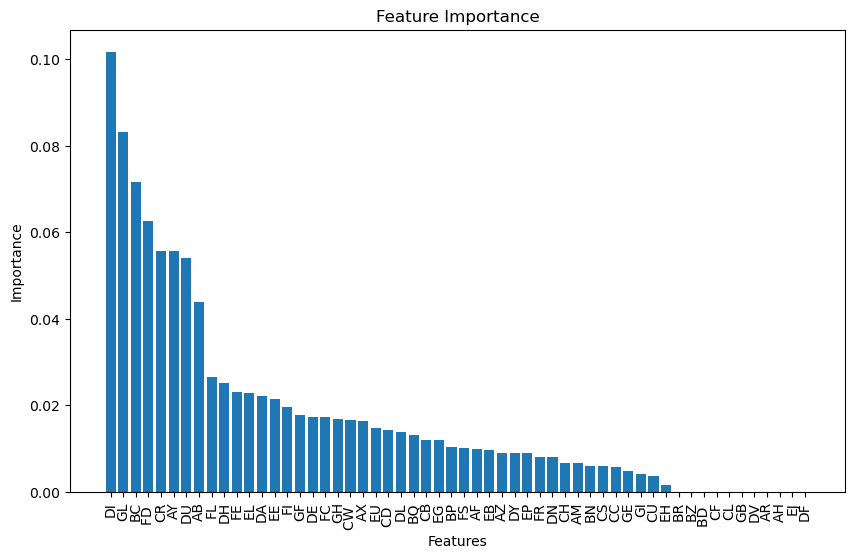

In [12]:

importance = best_model.feature_importances_
feature_names = feature_cols

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()




# LightGBM_CV 2.27 
# XGB_CV 0.188

# 今回のデータは少ないので、LGBMでは過学習が起きてしまっている？

# EDAより
# 標準偏差の20倍以上乖離しているものを極端な外れ値とみなす

# Index10,155,160,349,378,511 を見てみる

In [16]:
outlier_indices = [10, 155, 160, 349, 378, 511]
train_df.loc[outlier_indices]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
10,06055f3f6785,0.504214,6089.31532,85.200147,189.781063,17.027268,6.201300,10.315851,14.494600,212.628626,43882.27850,25.4232,198.444546,344.644105,51.216883,5917.108638,47.747245,0.769027,132.912920,20.952490,0.064476,1.050225,0.346200,17.086300,2.626092,50.579208,6.90640,189.658340,0.238680,0.308829,410.433945,102.01016,22.553320,0.005518,1.74307,27.783020,10.174386,1.439067,1586.677725,0.003042,0,109.125159,78.526968,67.687956,20.203344,0.296850,5635.427113,35.851039,0.173229,1.98969,0.067730,28.222268,126.449876,12115.894710,81.210825,72.990788,21.978000,1
155,3e2d6dca77ec,2.004037,3938.57904,142.078626,59.202252,10.446048,7.782631,0.116319,11.564170,8.897448,3274.25406,24.3639,156.847239,25.836390,179250.252900,1348.017839,12.499760,2.084044,146.660072,14.639374,0.029452,1.279365,0.358237,38.653395,1.103400,7.030640,16.78100,96.474555,2.682342,0.161247,206.062215,121.74736,9.355704,0.005518,1.74307,21.631226,6.870096,1.310075,1412.223850,0.003042,0,60.158241,145.708680,13.130952,25.247040,0.296850,21935.731720,6.025709,0.173229,0.49706,0.067730,19.180724,72.611063,9806.219316,27.847964,27.205330,21.978000,1
160,3f4bfe72745d,0.414481,3751.44407,85.200147,22.923994,8.138688,4.083999,0.025578,9.692476,50.696478,4277.31866,24.3639,138.288897,36.712265,852.270830,1205.928873,22.591478,0.189114,54.037248,10.955203,0.025472,1.050225,0.370350,32.083887,1.059264,23.056304,35.36038,146.377175,0.238680,0.235038,88.116060,105.00360,20.424232,2.082894,1.74307,10.439408,6.297588,0.749766,1005.096525,0.298116,1,47.878974,110.671860,33.273012,28.200144,2.517288,5530.974955,7.822947,3.568379,1244.22702,0.067730,16.343614,72.611063,329.158809,26.006069,23.065696,0.096377,1
349,8a3cb69b2242,0.192285,2524.13139,85.200147,31.192984,22.633104,5.590029,0.025578,11.129332,3.239908,4052.31227,13.7709,190.988145,112.890280,1414.912517,257.432377,100.034844,0.690428,123.209048,33.113449,0.017910,1.101145,0.991875,26.874309,2.184732,42.234256,88.54548,323.165145,0.238680,0.371688,253.689465,122.00176,37.170328,0.234498,1.74307,4.887296,8.693640,2.172709,1337.387325,0.085176,1,44.079750,78.526968,3.828384,18.592560,1.543620,1655.963088,7.563836,2.569701,1.98621,31.365763,23.143376,87.542732,47057.517160,17.764054,115.639692,0.244588,0
378,9230d1831db3,4.435374,4843.61790,1237.940805,630.518230,19.874760,11.250930,0.025578,12.950610,1463.693448,53060.59924,26.1294,810.149202,261.232005,513.832305,50092.459300,30.137289,4.103032,197.922520,200.967526,0.046566,1.820390,0.671625,43.088859,2.637126,7.030640,22.61652,809.924135,2.057562,0.128451,294.637605,110.40748,31.056024,0.005518,1.74307,14.715792,33.254940,1.019843,2358.251275,0.003042,0,77.337117,155.302095,46.188744,228.982656,0.296850,28756.668000,6.734129,0.173229,0.49706,1.313962,135.781294,363.134821,578.553354,43.256625,38.342090,21.978000,1
511,cf84868cd1ce,1.213532,4386.17256,85.200147,43.596469,10.739712,3.800511,0.025578,14.305540,5.952716,4121.79331,22.9515,339.810957,344.644105,791.154759,1168.837975,312.117169,0.455683,114.004640,17.072174,0.036218,1.050225,0.586275,39.169471,1.075815,36.623728,54.46744,107.380220,0.551772,0.169446,203.072805,90.15088,48.600528,161.355315,1.74307,29.440568,16.708752,1.971159,1323.493675,42.569748,1,109.125159,78.526968,55.344456,25.429824,1578.654237,7834.076542,11.042539,137.932739,2.29622,0.338650,23.673590,223.235180,1632.752964,32.406189,123.257956,0.177654,1


* AY/index10 : 0.1~0.3に対して10.31、約50倍。
* BR/index155 : 51~1400に対して179250、約130倍。
* FR/index160 : 0.5~2.5に対して1244、約500倍
* FS/index349 : 0.06~1.3に対して31.3、約30倍。
* BC・BZ/index378 : BC 3~212に対して1463、ばらつきあり。BZ 257~5917に対して50092、ばらつきあり。
* EH・FD/index511 : EH 0.003~0.29に対して42、約140倍。FD 0.3~2.5に対して1578、約600倍。

# 上記の結果によりindex160とindex511を削除する。データ数が少ないので除外は2つだけにします。

In [17]:
train_df = train_df.drop(index=[160, 511])

<function matplotlib.pyplot.show(close=None, block=None)>

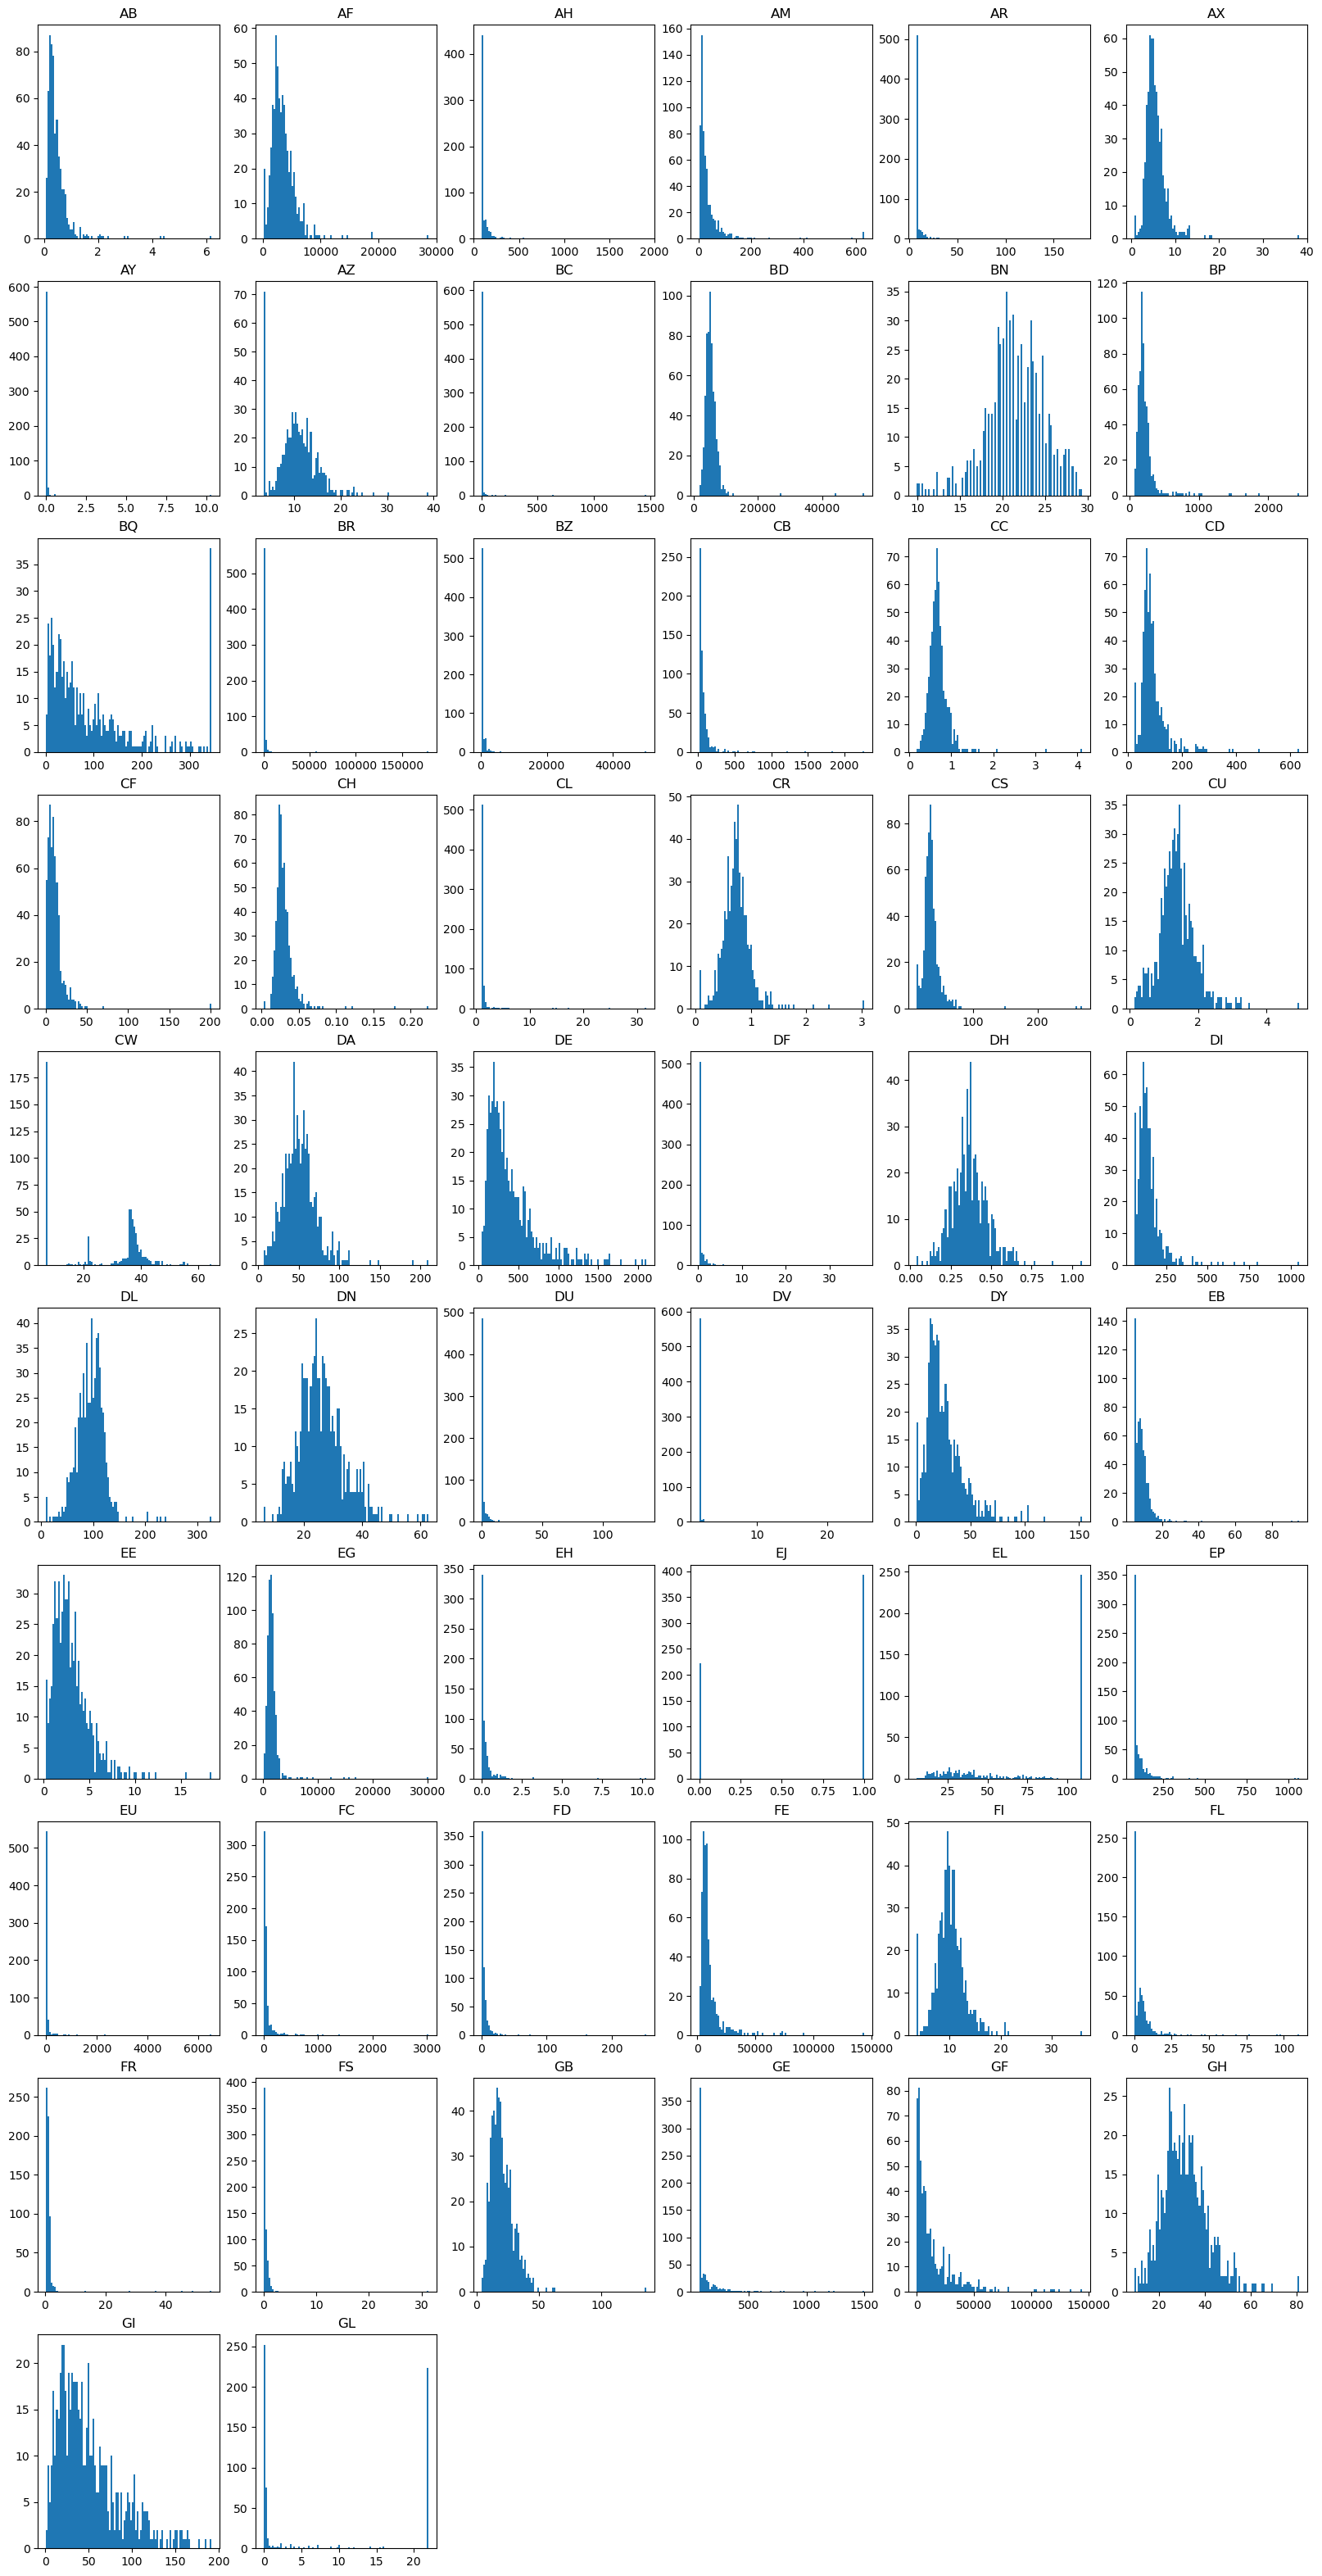

In [18]:
plt.figure(figsize=(20,40))
for i, col in enumerate(feature_cols) :
    plt.subplot(10, 6, i+1)
    plt.hist(train_df[col], bins=100)
    plt.title(col)
plt.show

FR,EH,FDにかなりの改善が見られた。
グラフの右端の数字を比較してみる
* FR(index160)：1000⇒40
* EH(index511)：40⇒10
* FD(index511)：1500⇒200

In [19]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,555.000000,615.000000,615.000000,613.000000,612.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,614.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,555.000000,615.000000,615.000000,614.000000,615.000000,615.000000,615.000000,614.000000,615.000000,613.000000,615.000000,615.000000,615.000000,615.000000,615.000000,614.000000,615.000000
mean,0.476054,3500.169985,118.733210,38.987116,10.130483,5.550790,0.060433,10.561788,7.987088,5354.131200,21.412214,231.297092,97.995946,1219.422410,548.561791,76.809697,0.689999,90.271998,11.232047,0.030614,1.404911,0.743120,36.921788,1.384821,27.156956,51.148535,402.795682,0.634660,0.367537,146.976579,94.786331,26.344091,1.542587,1.925421,26.409962,9.064796,3.070321,1733.091965,0.236396,0.639024,69.550454,105.094733,69.197683,71.486564,4.381612,10318.597030,10.113285,5.220439,1.518531,0.422213,20.727185,131.662277,14724.143819,31.497143,50.511015,8.558303,0.172358
std,0.468200,2303.767087,128.032731,69.838444,10.535660,2.554191,0.417490,4.354967,65.250212,3025.524936,3.481355,184.201647,96.048915,7587.587247,2079.431400,159.009936,0.263481,51.639503,13.591173,0.014829,1.925232,0.281181,17.293106,0.539291,14.663920,21.235436,317.872195,1.915426,0.112765,86.162046,28.285526,7.998129,6.347912,1.486934,18.134311,6.201705,2.059095,1792.824836,0.714393,0.480674,38.577654,68.548258,390.818944,165.801804,13.301070,11347.652404,2.937108,10.193352,3.914697,1.307414,10.005897,144.349203,19368.593368,9.877741,36.189566,10.332688,0.377999
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,9.886800,72.948951,1.331155,51.216883,257.432377,12.499760,0.176874,23.387600,0.510888,0.003184,1.050225,0.069225,13.784111,0.137925,7.030640,6.906400,35.998895,0.238680,0.040995,60.232470,10.345600,6.339496,0.005518,1.743070,0.804068,4.926396,0.286201,185.594100,0.003042,0.000000,5.394675,78.526968,3.828384,7.534128,0.296850,1563.136688,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2196.398050,85.200147,12.257926,8.138688,4.132723,0.025578,8.123278,1.229900,4156.693630,19.420500,156.993484,27.825308,424.890833,257.432377,23.317567,0.564379,64.740048,5.052621,0.023482,1.050225,0.590737,29.712727,1.070298,7.030640,37.960950,190.731610,0.238680,0.297214,102.844740,78.220580,20.915560,0.005518,1.743070,14.727022,5.960091,1.650694,1111.223888,0.003042,0.000000,30.903444,78.526968,4.267686,25.852512,0.296850,5160.769797,8.532746,0.173229,0.497060,0.067730,14.004161,72.611063,2812.012888,25.033027,22.929380,0.124757,0.000000
50%,0.354659,3109.033290,85.200147,20.505237,8.138688,5.040771,0.025578,10.461320,1.229900,5011.831370,21.186000,193.908816,61.642115,626.978850,257.432377,42.554330,0.659370,79.819104,9.116918,0.027860,1.050225,0.730875,34.835130,1.351665,36.019104,49.180940,308.019620,0.238680,0.358023,130.050630,96.264960,25.248800,0.244843,1.743070,21.642456,8.149404,2.620150,1494.076488,0.079092,1.000000,71.949306,78.526968,22.580376,36.471120,1.798911,7345.143424,9.945452,3.013995,1.129260,0.250601,18.771436,72.611063,7863.793713,30.608946,41.007968,0.339429,0.000000
75%,0.557627,4355.123960,113.817921,38.716371,8.138688,6.458211,0.037301,12.960063,5.032048,6036.001555,23.657700,247.265109,133.979058,975.984979,257.432377,77.264141,0.772337,99.801628,13.557538,0.034327,1.228445,0.859669,40.536375,1.660617,37.937258,61.422340,510.306623,0.238680,0.427031,165.774833,110.726540,30.533988,1.024204,1.743070,34.107756,10.503048,3.912085,1905.918375

FR,EH,FDにかなりの改善が見られた。

グラフの右端の数字：MAX値　を比較してみる。
* FR(index160) 1000⇒40 : 1244⇒54
* EH(index511)：40⇒10 : 42⇒10
* FD(index511)：1500⇒200 : 1578⇒252

# **Index160と511を削除した状態でModelを作る**

In [20]:
y = train_df['Class']
x = train_df[feature_cols]

In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model = lgbm.LGBMClassifier(n_estimators=239,
                               num_leaves=12,
                               max_depth=2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = log_loss(y_test, y_pred)
    scores.append(score)

mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}' )

Logloss_Score 1: 2.3443026594547742
Logloss_Score 2: 1.4651891621592337
Logloss_Score 3: 3.2234161567503143
Logloss_Score 4: 2.637340491886621
Logloss_Score 5: 1.7582269945910807
Logloss_mean: 2.2856950929684046


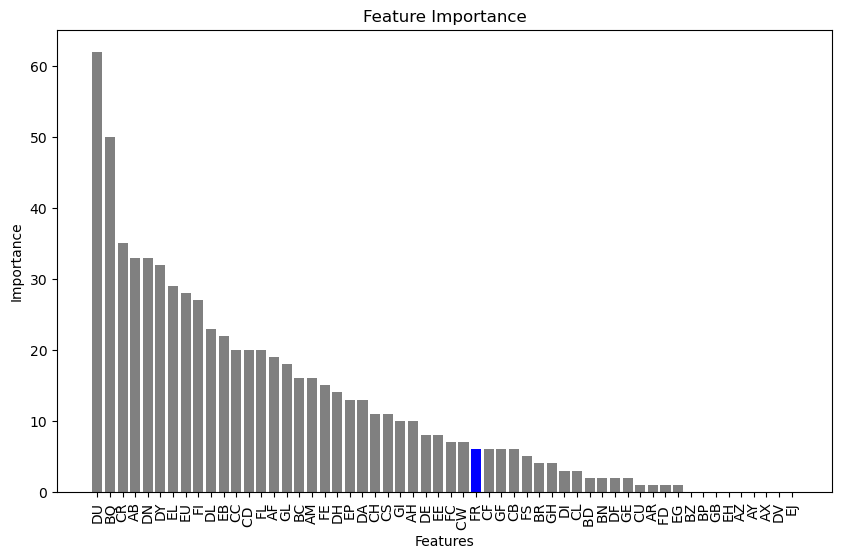

In [22]:
importance = model.feature_importances_
feature_names = feature_cols

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

colors = ['blue' if name.upper() in ['FR', 'FD', 'EH'] else 'gray' for name in sorted_feature_names]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance, color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# FR,FD,EH共に重要度は落ちた。

# XGBでモデルを構築する

In [36]:

y = train_df['Class']
x = train_df[feature_cols]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model = xgb.XGBClassifier()

# ハイパーパラメータのグリッドを定義
param_grid = {
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# GridSearchCVを使用してハイパーパラメータのチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
grid_search.fit(x, y)

# 最適なモデルとハイパーパラメータを取得
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

# ベストモデルを使用して評価
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict_proba(X_test)[:, 1]
    score = log_loss(y_test, y_pred)
    scores.append(score)
    
mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}')



Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6}
Logloss_Score 1: 0.17900451264215306
Logloss_Score 2: 0.08441072301047915
Logloss_Score 3: 0.3212911158068763
Logloss_Score 4: 0.20892495326859017
Logloss_Score 5: 0.21783212438882565
Logloss_mean: 0.2022926858233849


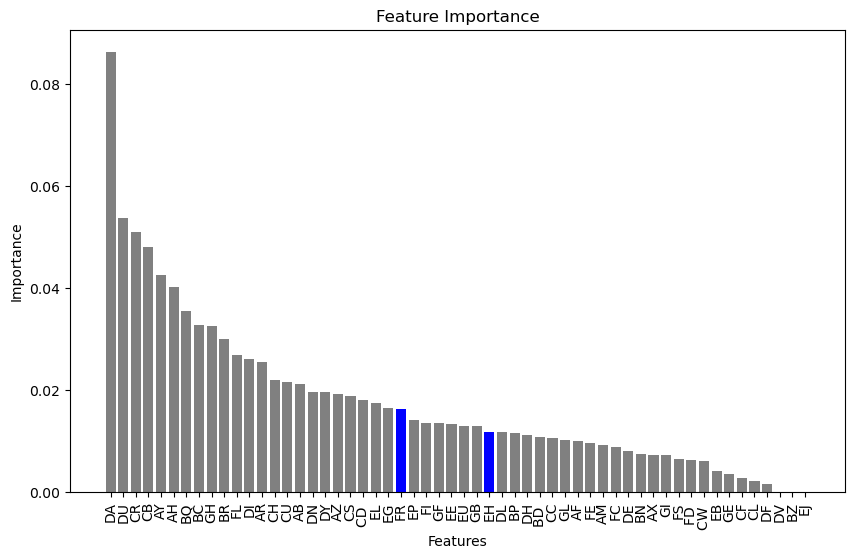

In [37]:

importance = best_model.feature_importances_
feature_names = feature_cols

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

colors = ['blue' if name.upper() in ['FR', 'FD', 'EH'] else 'gray' for name in sorted_feature_names]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance, color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()



# LGBM_CV 2.28
# XGB_CV 0.202

# LGBMとXGBで重要変数がかなり違う。

# **欠損値を平均値で補完してモデルを作成する。**

In [46]:
train_df[feature_cols] = train_df[feature_cols].fillna(train_df[feature_cols].mean())
test_df[feature_cols] = test_df[feature_cols].fillna(test_df[feature_cols].mean(numeric_only=True))

In [47]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,0.476054,3500.169985,118.733210,38.987116,10.130483,5.550790,0.060433,10.561788,7.987088,5354.131200,21.412214,231.297092,97.995946,1219.422410,548.561791,76.809697,0.689999,90.271998,11.232047,0.030614,1.404911,0.743120,36.921788,1.384821,27.156956,51.148535,402.795682,0.634660,0.367537,146.976579,94.786331,26.344091,1.542587,1.925421,26.409962,9.064796,3.070321,1733.091965,0.236396,0.639024,69.550454,105.094733,69.197683,71.486564,4.381612,10318.597030,10.113285,5.220439,1.518531,0.422213,20.727185,131.662277,14724.143819,31.497143,50.511015,8.558303,0.172358
std,0.468200,2303.767087,128.032731,69.838444,10.535660,2.554191,0.417490,4.354967,65.250212,3025.524936,3.481355,184.201647,91.235353,7587.587247,2079.431400,158.750751,0.262836,51.639503,13.591173,0.014829,1.925232,0.281181,17.293106,0.539291,14.663920,21.235436,317.872195,1.915426,0.112765,86.162046,28.285526,7.998129,6.342741,1.486934,18.134311,6.201705,2.059095,1792.824836,0.714393,0.480674,36.644307,68.548258,390.818944,165.666732,13.301070,11347.652404,2.937108,10.185048,3.914697,1.305283,10.005897,144.349203,19368.593368,9.877741,36.189566,10.324271,0.377999
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,9.886800,72.948951,1.331155,51.216883,257.432377,12.499760,0.176874,23.387600,0.510888,0.003184,1.050225,0.069225,13.784111,0.137925,7.030640,6.906400,35.998895,0.238680,0.040995,60.232470,10.345600,6.339496,0.005518,1.743070,0.804068,4.926396,0.286201,185.594100,0.003042,0.000000,5.394675,78.526968,3.828384,7.534128,0.296850,1563.136688,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2196.398050,85.200147,12.257926,8.138688,4.132723,0.025578,8.123278,1.229900,4156.693630,19.420500,156.993484,30.053234,424.890833,257.432377,23.363522,0.564510,64.740048,5.052621,0.023482,1.050225,0.590737,29.712727,1.070298,7.030640,37.960950,190.731610,0.238680,0.297214,102.844740,78.220580,20.915560,0.005518,1.743070,14.727022,5.960091,1.650694,1111.223888,0.003042,0.000000,32.979375,78.526968,4.267686,25.863936,0.296850,5160.769797,8.532746,0.173229,0.497060,0.067730,14.004161,72.611063,2812.012888,25.033027,22.929380,0.125101,0.000000
50%,0.354659,3109.033290,85.200147,20.505237,8.138688,5.040771,0.025578,10.461320,1.229900,5011.831370,21.186000,193.908816,73.295582,626.978850,257.432377,42.673813,0.660394,79.819104,9.116918,0.027860,1.050225,0.730875,34.835130,1.351665,36.019104,49.180940,308.019620,0.238680,0.358023,130.050630,96.264960,25.248800,0.248292,1.743070,21.642456,8.149404,2.620150,1494.076488,0.079092,1.000000,69.550454,78.526968,22.580376,36.488256,1.798911,7345.143424,9.945452,3.019391,1.129260,0.257374,18.771436,72.611063,7863.793713,30.608946,41.007968,0.339429,0.000000
75%,0.557627,4355.123960,113.817921,38.716371,8.138688,6.458211,0.037301,12.960063,5.032048,6036.001555,23.657700,247.265109,122.742390,975.984979,257.432377,77.082619,0.772107,99.801628,13.557538,0.034327,1.228445,0.859669,40.536375,1.660617,37.937258,61.422340,510.306623,0.238680,0.427031,165.774833,110.726540,30.533988,1.041447,1.743070,34.107756,10.503048,3.912085,1905.918375

In [48]:
y = train_df['Class']
x = train_df[feature_cols]

In [49]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model = lgbm.LGBMClassifier(n_estimators=239,
                               num_leaves=12,
                               max_depth=2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = log_loss(y_test, y_pred)
    scores.append(score)

mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}' )



Logloss_Score 1: 2.637340491886621
Logloss_Score 2: 1.7582269945910807
Logloss_Score 3: 2.9303783243184673
Logloss_Score 4: 2.9303783243184673
Logloss_Score 5: 1.7582269945910807
Logloss_mean: 2.402910225941143


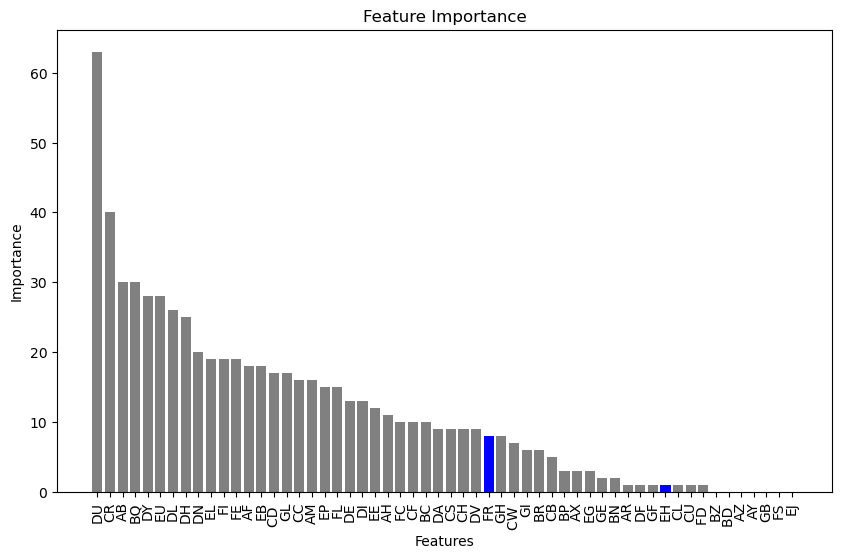

In [50]:

importance = model.feature_importances_
feature_names = feature_cols

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

colors = ['blue' if name.upper() in ['FR', 'FD', 'EH'] else 'gray' for name in sorted_feature_names]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance, color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()



In [53]:

y = train_df['Class']
x = train_df[feature_cols]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model = xgb.XGBClassifier()

# ハイパーパラメータのグリッドを定義
param_grid = {
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# GridSearchCVを使用してハイパーパラメータのチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
grid_search.fit(x, y)

# 最適なモデルとハイパーパラメータを取得
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

# ベストモデルを使用して評価
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict_proba(X_test)[:, 1]
    score = log_loss(y_test, y_pred)
    scores.append(score)
    
mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}')





Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6}
Logloss_Score 1: 0.17900451264215306
Logloss_Score 2: 0.08441072301047915
Logloss_Score 3: 0.3212911158068763
Logloss_Score 4: 0.20892495326859017
Logloss_Score 5: 0.21783212438882565
Logloss_mean: 0.2022926858233849


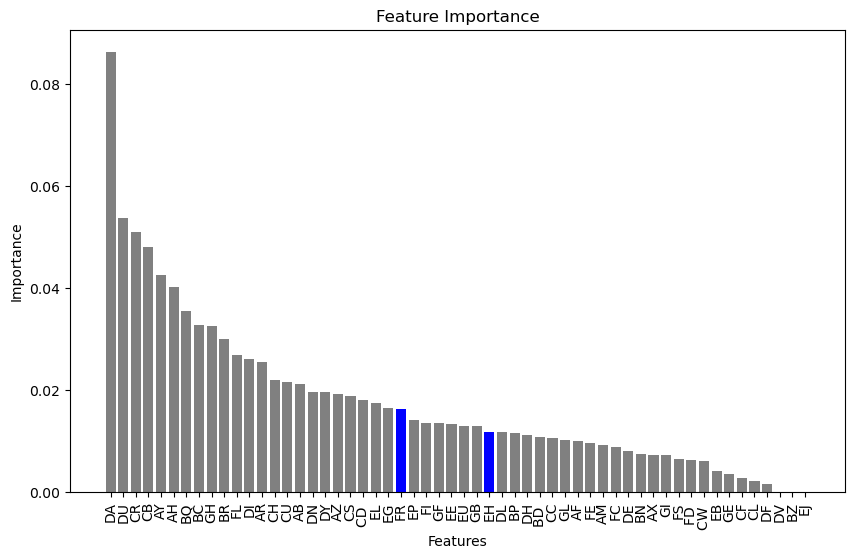

In [54]:

importance = best_model.feature_importances_
feature_names = feature_cols

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

colors = ['blue' if name.upper() in ['FR', 'FD', 'EH'] else 'gray' for name in sorted_feature_names]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance, color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()



# **LGBM LB 0.33 CV 2.40**
# **XGB_CV 0.202**